In [2]:
import numpy as np

# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio

import sys
sys.path.append('../../tools/')
import fitting_functions

import matplotlib.colors

import matplotlib.ticker as ticker

import scipy.optimize
import tqdm.notebook

# Utility functions

In [4]:
def loadBestFits(filename, n):
    fit_file = sio.loadmat(filename)
    lls = fit_file['lls']
    fits = fit_file['fits']
    best_trace_ind = np.argmax(lls[n-1,:])
    best_fits = np.zeros((fits.shape[1], fits[n-1,0].shape[1]))
    for i in range(fits.shape[1]):
        best_fits[i,:] = fits[n-1,i][best_trace_ind,:]
    return best_fits

In [6]:
def calculateAUC(plant_params, T = 20, total=False, normalized=True):
    """Calculate the area under the curve given plant model parameters. Uses the continuum limit.
    
    Arguments:
        plant_params: array of length 2*n, concatenating the coefficients and inverse plant time constants
        T: length of time over which to calculate area (s), using definite integral
        total: True to return the total AUC
        normalized: True to divide components by total AUC
        
    Returns:
        a scalar value of the total AUC (if total == True), or
        an array of length n giving the AUC for each component (if Total == False)
    """
    n = len(plant_params)//2
    sort_order = np.flip(np.argsort(plant_params[n:]))
    timeconstants = plant_params[n+sort_order]
    c = plant_params[sort_order]
    aucs = np.zeros(n)
    for k in range(n):
        if timeconstants[k] > 0:
            aucs[k] = 1./timeconstants[k]*c[k]*(1-np.exp(-T*timeconstants[k]))
        else:
            aucs[k] = c[k]*T
    if total:
        return np.sum(aucs)
    else:
        if normalized:
            return aucs/np.sum(aucs)
        else:
            return aucs

In [7]:
def deconvolveEyePos(trange, eye_pos, plant, ind=-1, mode='lsq_linear'):
    """Compute applied force given eye position and plant parameters.
    
    Arguments:
        trange: time array for eye position
        eye_pos: eye position data
        plant: 2*n parameter array of coefficients and inverse time constants
        ind: index of eye position after which force goes to zero (-1 if none)
        mode: optimization method to use ('lsq_linear' or 'nnls')
    """
    plant_model = fitting_functions.exponentialModel(trange, plant)
    
    def convMat(signal, m):
        mat = np.zeros((len(signal), m))
        mat[:,0] = signal
        for i in range(1, m):
            mat[i:,i] = signal[:len(signal)-i]
        return mat
    
    if ind == -1:
        ind = len(trange)
    mat = 72*2e-4*convMat(plant_model, ind)
    
    f_ = np.zeros(len(trange))
    if mode == 'lsq_linear':
        optresult = scipy.optimize.lsq_linear(mat, eye_pos, bounds=(0, np.inf))
        f_ = np.zeros(len(trange))
        f_[:len(optresult.x)] = optresult.x
    elif mode == 'nnls':
        x, err_ = scipy.optimize.nnls(mat, eye_pos)
        f_[:len(x)] = x
    
    return f_

In [8]:
# Set rcParams for plotting
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

In [9]:
ms222_traces = ['091311a', '091311b', '091311c', '091311d', '091311e', '091311f', '091411a', '091411d', '091411e', '091411f']
ketamine_traces = ['63011d','70911i', '70911l', '70911m', '82411p', '82411r']

# Parameter summary

In [10]:
# Load MS-222 plants

num_components = 4

best_plants_ms222 = np.zeros((len(ms222_traces), num_components*2))
aucs_ms222 = np.zeros((len(ms222_traces), num_components))
for i in range(len(ms222_traces)):
    trace = ms222_traces[i]
    
    # load time constants from step response fits
    fit_file = sio.loadmat('fit/results/MS-222/'+trace+'.mat')
    fit_lls = fit_file['lls']
    best_trace_ind = np.argmax(fit_lls[num_components-1,:])
    fit_fits = fit_file['fits']
    timeconstants = fit_fits[num_components-1,0][best_trace_ind, num_components:]
    
    # load coefficients from linear blind deconvolution
    deconv_file = sio.loadmat('deconv/results/MS-222/'+trace+'/distributed/linear.mat')
    best_plants_ms222[i,:] = np.concatenate((deconv_file['c'][0], timeconstants))
    aucs_ms222[i,:] = calculateAUC(best_plants_ms222[i,:], T=60, normalized=True)

In [13]:
best_plants_ketamine = np.zeros((len(ketamine_traces), num_components*2))
aucs_ketamine = np.zeros((len(ketamine_traces), num_components))
for i in range(len(ketamine_traces)):
    trace = ketamine_traces[i]
    
    # load time constants from step response fits
    fit_file = sio.loadmat('fit/results/Ketamine/'+trace+'.mat')
    fit_lls = fit_file['lls']
    best_trace_ind = np.argmax(fit_lls[num_components-1,:])
    fit_fits = fit_file['fits']
    timeconstants = fit_fits[num_components-1,0][best_trace_ind, num_components:]
    
    # load coefficients from linear blind deconvolution
    deconv_file = sio.loadmat('deconv/results/Ketamine/'+trace+'/distributed/linear.mat')
    best_plants_ketamine[i,:] = np.concatenate((deconv_file['c'][0], timeconstants))
    aucs_ketamine[i,:] = calculateAUC(best_plants_ketamine[i,:], T=60, normalized=True)

### Plant coefficients and time constants are related by an approximate power law

In [14]:
# Fit a line between log(coefficients) and log(time constants)

p_ms222 = np.polyfit(np.log(np.concatenate(1/best_plants_ms222[:,4:])),
                        np.log(np.concatenate(best_plants_ms222[:,:4])+1e-5), 1) # add 1e-5 to account for one coefficient that is zero

p_ketamine = np.polyfit(np.log(np.concatenate(1/best_plants_ketamine[:,4:])),
                        np.log(np.concatenate(best_plants_ketamine[:,:4])), 1)

In [15]:
# Repeating procedure for plant from appendix of Sklavos et al. 2005

sklavos_plant = np.array([0.915, 0.0776, 0.007, 0.000287, 1/0.0115,1/0.099, 1/0.455, 1/7.76 ])
p_sklavos = np.polyfit(np.log(1/sklavos_plant[4:]), np.log(sklavos_plant[:4]),1)

In [20]:
print("Slope (exponent):\nMS-222: %.3f\nKetamine: %.3f\nSklavos: %.3f" %(p_ms222[0], p_ketamine[0], p_sklavos[0]))

Slope (exponent):
MS-222: -0.878
Ketamine: -1.008
Sklavos: -1.255


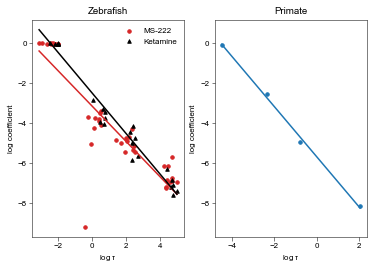

In [38]:
x_lims = np.min(np.log(np.concatenate(1/best_plants_ms222[:,4:]))), \
            np.max(np.log(np.concatenate(1/best_plants_ms222[:,4:])))
    
x = np.linspace(x_lims[0], x_lims[1])

plt.subplot(1,2,1)
plt.scatter(np.log(np.concatenate(1/best_plants_ms222[:,4:])),
                        np.log(np.concatenate(best_plants_ms222[:,:4])+1e-4), 12, c='C3', label='MS-222')
plt.scatter(np.log(np.concatenate(1/best_plants_ketamine[:,4:])),
                        np.log(np.concatenate(best_plants_ketamine[:,:4])), 12, marker='^', c='k', label='Ketamine')

plt.plot(x, x*p_ms222[0]+p_ms222[1], c='C3')
plt.plot(x, x*p_ketamine[0] + p_ketamine[1], c='k')
ylims = plt.ylim()
plt.title('Zebrafish')
plt.xlabel(r'log $\tau$')
plt.ylabel('log coefficient')
plt.legend(frameon=False)

plt.subplot(1,2,2)
x_lims_sklavos = np.min(np.log(1/sklavos_plant[4:])), \
            np.max(np.log(1/sklavos_plant[4:]))
    
x_sklavos = np.linspace(x_lims_sklavos[0], x_lims_sklavos[1])
plt.scatter(np.log(1/sklavos_plant[4:]), np.log(sklavos_plant[:4]), 12)
plt.plot(x_sklavos, x_sklavos*p_sklavos[0] + p_sklavos[1])
plt.ylim(ylims)
plt.title('Primate')
plt.xlabel(r'log $\tau$')
plt.ylabel('log coefficient');

## Figure 5D: parameter summary of recovered plant models

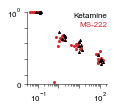

In [13]:
fig = plt.figure(figsize=(1.3,1.3))
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim([0.25e-4, 1])


for i in range(len(ms222_traces)):
    plt.scatter(1./best_plants_ms222[i,num_components:], np.maximum(0.35e-4, best_plants_ms222[i,:num_components]), 4,c='C3', clip_on=False)

for i in range(len(ketamine_traces)):
    plt.scatter(1./best_plants_ketamine[i,num_components:], best_plants_ketamine[i,:num_components],4, marker='^', c='k', clip_on=False)

ax.get_xaxis().set_minor_locator(ticker.LogLocator(numticks=5, subs='all'))
ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())

ax.set_xticks([1e-1, 1e0, 1e1, 1e2])
ax.set_xticklabels([r'$10^{-1}$','' , '', r'$10^{2}$'])

ax.set_yticks([0.25e-4, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_yticklabels([0, '', '', '', '', r'$10^{0}$'])

ax.get_yaxis().set_minor_locator(ticker.LogLocator(numticks=5, subs='all'))
ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())

plt.figtext(0.98, 0.8, 'MS-222', color='C3', horizontalalignment='right', fontsize=8)
plt.figtext(0.98,0.9, 'Ketamine', horizontalalignment='right', fontsize=8)

plt.subplots_adjust(left = 0.12, top = 0.95, bottom=0.18, right=0.98)

## Figure 5E: AUC summary

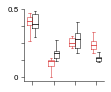

In [39]:
fig = plt.figure(figsize=(1.3,1.3))
ax = plt.gca()

plt.boxplot(aucs_ms222, positions=np.arange(1,5)-0.125, whis=(0,100), widths=0.25, medianprops={'c':'C3', 'linewidth':0.75},
            boxprops={'c':'C3', 'linewidth':0.5}, whiskerprops={'c':'C3','linewidth':0.5}, 
            capprops={'c':'C3', 'linewidth':0.5});
plt.boxplot(aucs_ketamine, positions=np.arange(1,5)+0.125, whis=(0,100), widths=0.25, medianprops={'c':'k', 'linewidth':0.75},
            boxprops={'linewidth':0.5}, whiskerprops={'linewidth':0.5}, capprops={'linewidth':0.5});



plt.ylim([-0.03, 0.5])
plt.yticks(np.linspace(0, 0.5, 5))
ax.set_yticklabels([0, '', '', '', 0.5])

plt.xlim([0.6, 4.4])
ax.set_xticks([1,2,3,4])
ax.set_xticklabels([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplots_adjust(left = 0.12, top = 0.95, bottom=0.18, right=0.98)

# Example traces, MS-222

In [75]:
fish_num = 0 # (same as used for step responses)

short_duration = 10
long_duration = 60

# Load step response fits
trange, pe_short, pe_long = fitting_functions.importDataMS222('../../data/anesthetized/fixed/MS-222/'+ms222_traces[fish_num]+'.mat')
best_fits = loadBestFits('fit/results/MS-222/'+ms222_traces[fish_num]+'.mat', 4)
timeconstants = best_fits[0, 4:]

# Bridge the gap between release time and real data
trange_deconv_mid = np.arange(0, int(0.2304/(72*2e-4))+1)*72*2e-4
pe_short_deconv_mid = fitting_functions.exponentialModel(trange_deconv_mid, best_fits[0,:])
pe_long_deconv_mid = fitting_functions.exponentialModel(trange_deconv_mid, best_fits[1,:])

# Construct 10 s hold
trange_short_deconv_pre = np.arange(0, short_duration, 72*2e-4)
pe_short_deconv_pre = np.ones(len(trange_short_deconv_pre))
# Construct 60 s hold
trange_long_deconv_pre = np.arange(0, long_duration, 72*2e-4)
pe_long_deconv_pre = np.ones(len(trange_long_deconv_pre))

### Compute reconstruction
trange_short_deconv = np.concatenate((trange_short_deconv_pre, trange_deconv_mid + short_duration, short_duration+trange[1:]))
trange_long_deconv = np.concatenate((trange_long_deconv_pre, trange_deconv_mid + long_duration, long_duration+trange[1:]))

pe_short_deconv = np.concatenate((pe_short_deconv_pre, pe_short_deconv_mid, pe_short[1:]))
pe_long_deconv = np.concatenate((pe_long_deconv_pre, pe_long_deconv_mid, pe_long[1:]))

# Best reconstruction
plant_model_best_short = fitting_functions.exponentialModel(trange_short_deconv, best_plants_ms222[fish_num,:])
f_best_short = np.zeros(len(trange_short_deconv))
f_best_short[:len(pe_short_deconv_pre)] = deconvolveEyePos(trange_short_deconv_pre, pe_short_deconv_pre, best_plants_ms222[fish_num,:], mode='nnls')
reconstr_best_short = 72*2e-4*np.convolve(plant_model_best_short, f_best_short)[:len(plant_model_best_short)]

plant_model_best_long = fitting_functions.exponentialModel(trange_long_deconv, best_plants_ms222[fish_num,:])
f_best_long = np.zeros(len(trange_long_deconv))
f_best_long[:len(pe_long_deconv_pre)] = deconvolveEyePos(trange_long_deconv_pre, pe_long_deconv_pre, best_plants_ms222[fish_num,:], mode='nnls')
reconstr_best_long = 72*2e-4*np.convolve(plant_model_best_long, f_best_long)[:len(plant_model_best_long)]

# Reconstruction using plant w/ only 2 fastest time constants
deconv_file_fast = sio.loadmat('deconv/results/MS-222/'+ms222_traces[fish_num]+'/fast/linear.mat')
timeconstants_fast = np.sort(best_fits[0,4:])[-2:]
fast_plant = np.concatenate((deconv_file_fast['c'][0], timeconstants_fast))
plant_model_fast_short = fitting_functions.exponentialModel(trange_short_deconv, fast_plant)
f_fast_short = np.zeros(len(trange_short_deconv))
f_fast_short[:len(pe_short_deconv_pre)] = deconvolveEyePos(trange_short_deconv_pre, pe_short_deconv_pre, fast_plant, mode='nnls')
reconstr_fast_short = 72*2e-4*np.convolve(plant_model_fast_short, f_fast_short)[:len(plant_model_fast_short)]

plant_model_fast_long = fitting_functions.exponentialModel(trange_long_deconv, fast_plant)
f_fast_long = np.zeros(len(trange_long_deconv))
f_fast_long[:len(pe_long_deconv_pre)] = deconvolveEyePos(trange_long_deconv_pre, pe_long_deconv_pre, fast_plant, mode='nnls')
reconstr_fast_long = 72*2e-4*np.convolve(plant_model_fast_long, f_fast_long)[:len(plant_model_fast_long)]

In [76]:
trange_short_plot = np.concatenate((trange_short_deconv_pre, short_duration+trange[1:]))
pe_short_plot = np.concatenate((pe_short_deconv_pre, pe_short[1:]))

trange_long_plot = np.concatenate((trange_long_deconv_pre, long_duration+trange[1:]))
pe_long_plot = np.concatenate((pe_long_deconv_pre, pe_long[1:]))

## Figure 5B
### 10 s, MS-222

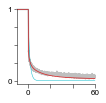

In [77]:
fig = plt.figure(figsize=(1.3,1.3))
ax = plt.gca() # plt.subplot(1,2,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(trange_short_plot-10, pe_short_plot, color=(0.75, 0.75, 0.75, 1),clip_on=False)
plt.plot(trange_short_deconv-10, reconstr_fast_short,c='C9', linewidth=0.5, clip_on=False)
plt.plot(trange_short_deconv-10, reconstr_best_short, c='C3', clip_on=False, linewidth=0.75)


plt.xlim([-10, 60])
plt.ylim([-0.05,1])

ax.set_xticks([0, 20, 40, 60])
ax.set_xticklabels([0, '','',60])
ax.set_yticks(np.linspace(0, 1, 5))
ax.set_yticklabels([0, '','','',1])

plt.subplots_adjust(left = 0.12, top = 0.98, bottom=0.18, right=0.95, wspace=0.3)

### 60 s, MS-222

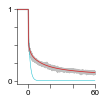

In [78]:
fig = plt.figure(figsize=(1.3,1.3))
ax = plt.gca() # plt.subplot(1,2,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(trange_long_plot[3473:]-60, pe_long_plot[3473:], color=(0.75, 0.75, 0.75, 1),clip_on=False)
plt.plot(trange_long_deconv[3473:]-60, reconstr_fast_long[3473:],c='C9', linewidth=0.5, clip_on=False)
plt.plot(trange_long_deconv[3473:]-60, reconstr_best_long[3473:], c='C3', clip_on=False, linewidth=0.75)


plt.xlim([-10, 60])
plt.ylim([-0.05,1])

ax.set_xticks([0, 20, 40, 60])
ax.set_xticklabels([0, '','',60])
ax.set_yticks(np.linspace(0, 1, 5))
ax.set_yticklabels([0, '','','',1])

plt.subplots_adjust(left = 0.12, top = 0.98, bottom=0.18, right=0.95, wspace=0.3)

## Force profiles, MS-222

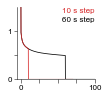

In [79]:
plt.figure(figsize=(1.3, 1.3))
plt.plot(trange_long_deconv, f_best_long/f_best_long[1], c='k', lw=0.75, label='60 s step')
plt.plot(trange_short_deconv, f_best_short/f_best_short[1], c='C3', lw=0.75, label='10 s step')

plt.xlim([-5, 100])
plt.ylim([0, 1.5])
ax = plt.gca()
ax.set_yticks(np.linspace(0,1,3))
ax.set_yticklabels([0, '',1])

ax.set_xticks(np.linspace(0, 100, 5))
ax.set_xticklabels([0, '', '', '', 100])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.figtext(0.95, 0.9, '10 s step', color='C3', horizontalalignment='right')
plt.figtext(0.95, 0.8, '60 s step', color='k', horizontalalignment='right')

plt.subplots_adjust(left=0.12, right=0.95, bottom=0.18, top=0.95)

## Plant shape, MS-222

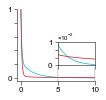

In [80]:
plt.figure(figsize=(1.3, 1.3))

plant_trange = np.arange(0, 10, 72*2e-4)
plt.plot(plant_trange, fitting_functions.exponentialModel(plant_trange, fast_plant), c='C9', lw=0.75, label=r'Fastest 2 $\tau$ plant')
plt.plot(plant_trange, fitting_functions.exponentialModel(plant_trange, best_plants_ms222[fish_num, :]), c='C3', lw=0.75, label=r'Best 4 $\tau$ plant')

ax = plt.gca()
plt.xlim([-0.5, 10])

plt.ylim([-0.05, 1])
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels([0, '','','','',1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0.12, right=0.95, bottom=0.18, top=0.95)



ax1 = plt.axes([.555, .35, .395, .25])

plt.plot(plant_trange[347:694], fitting_functions.exponentialModel(plant_trange[347:694], fast_plant), c='C9', lw=0.75)
plt.plot(plant_trange[347:694], fitting_functions.exponentialModel(plant_trange[347:694], best_plants_ms222[fish_num, :]), c='C3', lw=0.75)
ax1.set_xticks([5, 10])
ax1.set_xticklabels([])
ax1.set_ylim([0, 1e-2])
ax1.set_yticks(np.linspace(0,1e-2, 4))
ax1.set_yticklabels([0, '', '', 1])


ax1.set_xlim([5, 10])
plt.figtext(0.55, 0.62, r'$\times 10^{-2}$', fontsize=6)
ax.annotate("",xy=(5, 0.18), xytext=(5, -0.075),arrowprops={'arrowstyle':'-','ls':'--','lw':0.5, 'color':(0.5, 0.5, 0.5, 1)}, clip_on=False)
ax.annotate("",xy=(10, 0.18), xytext=(10, -0.075),arrowprops={'arrowstyle':'-','ls':'--','lw':0.5, 'color':(0.5, 0.5, 0.5, 1)}, clip_on=False);

# Example traces, Ketamine

In [81]:
fish_num = 0

short_duration = 15
long_duration = 90

# load fits
trange, pe_short, pe_long = fitting_functions.importDataKetamine('../../data/anesthetized/fixed/Ketamine/'+ketamine_traces[fish_num]+'.mat')
best_fits = loadBestFits('fit/results/Ketamine/'+ketamine_traces[fish_num]+'.mat', 4)
timeconstants = best_fits[0, 4:]

# Bridge the gap between release time and real data
trange_deconv_mid = np.arange(0, int(0.2304/(72*2e-4))+1)*72*2e-4
pe_short_deconv_mid = fitting_functions.exponentialModel(trange_deconv_mid, best_fits[0,:])
pe_long_deconv_mid = fitting_functions.exponentialModel(trange_deconv_mid, best_fits[1,:])

# Construct 10 s hold
trange_short_deconv_pre = np.arange(0, short_duration, 72*2e-4)
pe_short_deconv_pre = np.ones(len(trange_short_deconv_pre))
# Construct 60 s hold
trange_long_deconv_pre = np.arange(0, long_duration, 72*2e-4)
pe_long_deconv_pre = np.ones(len(trange_long_deconv_pre))

trange_short_deconv = np.concatenate((trange_short_deconv_pre, short_duration+trange_deconv_mid, short_duration+0.2304+trange[1:]))
trange_long_deconv = np.concatenate((trange_long_deconv_pre, long_duration+trange_deconv_mid, long_duration+0.2304+trange[1:]))

pe_short_deconv = np.concatenate((pe_short_deconv_pre, pe_short_deconv_mid, pe_short[1:]))
pe_long_deconv = np.concatenate((pe_long_deconv_pre, pe_long_deconv_mid, pe_long[1:]))

# Best reconstruction
plant_model_best_short = fitting_functions.exponentialModel(trange_short_deconv, best_plants_ketamine[fish_num,:])
f_best_short = np.zeros(len(trange_short_deconv))
f_best_short[:len(pe_short_deconv_pre)] = deconvolveEyePos(trange_short_deconv_pre, pe_short_deconv_pre, best_plants_ketamine[fish_num,:], mode='nnls')
reconstr_best_short = 72*2e-4*np.convolve(plant_model_best_short, f_best_short)[:len(plant_model_best_short)]

plant_model_best_long = fitting_functions.exponentialModel(trange_long_deconv, best_plants_ketamine[fish_num,:])
f_best_long = np.zeros(len(trange_long_deconv))
f_best_long[:len(pe_long_deconv_pre)] = deconvolveEyePos(trange_long_deconv_pre, pe_long_deconv_pre, best_plants_ketamine[fish_num,:], mode='nnls')
reconstr_best_long = 72*2e-4*np.convolve(plant_model_best_long, f_best_long)[:len(plant_model_best_long)]

# Fast reconstruction
deconv_file_fast = sio.loadmat('deconv/results/Ketamine/'+ketamine_traces[fish_num]+'/fast/linear.mat')
timeconstants_fast = np.sort(best_fits[0,4:])[-2:]
fast_plant = np.concatenate((deconv_file_fast['c'][0], timeconstants_fast))
plant_model_fast_short = fitting_functions.exponentialModel(trange_short_deconv, fast_plant)
f_fast_short = np.zeros(len(trange_short_deconv))
f_fast_short[:len(pe_short_deconv_pre)] = deconvolveEyePos(trange_short_deconv_pre, pe_short_deconv_pre, fast_plant, mode='nnls')
reconstr_fast_short = 72*2e-4*np.convolve(plant_model_fast_short, f_fast_short)[:len(plant_model_fast_short)]

plant_model_fast_long = fitting_functions.exponentialModel(trange_long_deconv, fast_plant)
f_fast_long = np.zeros(len(trange_long_deconv))
f_fast_long[:len(pe_long_deconv_pre)] = deconvolveEyePos(trange_long_deconv_pre, pe_long_deconv_pre, fast_plant, mode='nnls')
reconstr_fast_long = 72*2e-4*np.convolve(plant_model_fast_long, f_fast_long)[:len(plant_model_fast_long)]

In [82]:
trange_short_plot = np.concatenate((trange_short_deconv_pre, short_duration+trange[1:]))
pe_short_plot = np.concatenate((pe_short_deconv_pre, pe_short[1:]))

trange_long_plot = np.concatenate((trange_long_deconv_pre, long_duration+trange[1:]))
pe_long_plot = np.concatenate((pe_long_deconv_pre, pe_long[1:]))

## 15s, Ketamine

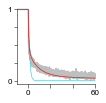

In [83]:
fig = plt.figure(figsize=(1.3,1.3))
ax = plt.gca() # plt.subplot(1,2,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(trange_short_plot[348:]-15, pe_short_plot[348:], color=(0.75, 0.75, 0.75, 1),clip_on=False)
plt.plot(trange_short_deconv[348:]-15, reconstr_fast_short[348:],c='C9', linewidth=0.5, clip_on=False)
plt.plot(trange_short_deconv[348:]-15, reconstr_best_short[348:], c='C3', clip_on=False, linewidth=0.75)


plt.xlim([-10, 60])
plt.ylim([-0.05,1])

ax.set_xticks([0, 20, 40, 60])
ax.set_xticklabels([0, '','',60])
ax.set_yticks(np.linspace(0, 1, 5))
ax.set_yticklabels([0, '','','',1])

plt.subplots_adjust(left = 0.12, top = 0.98, bottom=0.18, right=0.95, wspace=0.3)

## 90 s, MS-222

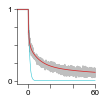

In [84]:
fig = plt.figure(figsize=(1.3,1.3))
ax = plt.gca() # plt.subplot(1,2,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(trange_long_plot[5556:]-90, pe_long_plot[5556:], color=(0.75, 0.75, 0.75, 1),clip_on=False)
plt.plot(trange_long_deconv[5556:]-90, reconstr_fast_long[5556:],c='C9', linewidth=0.5, clip_on=False)
plt.plot(trange_long_deconv[5556:]-90, reconstr_best_long[5556:], c='C3', clip_on=False, linewidth=0.75)


plt.xlim([-10, 60])
plt.ylim([-0.05,1])

ax.set_xticks([0, 20, 40, 60])
ax.set_xticklabels([0, '','',60])
ax.set_yticks(np.linspace(0, 1, 5))
ax.set_yticklabels([0, '','','',1])

plt.subplots_adjust(left = 0.12, top = 0.98, bottom=0.18, right=0.95, wspace=0.3)

## Force profiles, MS-222

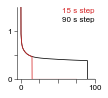

In [85]:
plt.figure(figsize=(1.3, 1.3))
plt.plot(trange_long_deconv, f_best_long/f_best_long[1], c='k', lw=0.75, label='90 s step')
plt.plot(trange_short_deconv, f_best_short/f_best_short[1], c='C3', lw=0.75, label='15 s step')

plt.xlim([-5, 100])
plt.ylim([0, 1.5])
ax = plt.gca()
ax.set_yticks(np.linspace(0,1,3))
ax.set_yticklabels([0, '',1])

ax.set_xticks(np.linspace(0, 100, 5))
ax.set_xticklabels([0, '', '', '', 100])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.figtext(0.95, 0.9, '15 s step', color='C3', horizontalalignment='right')
plt.figtext(0.95, 0.8, '90 s step', color='k', horizontalalignment='right')

plt.subplots_adjust(left=0.12, right=0.95, bottom=0.18, top=0.95)

# Plant shape, MS-222

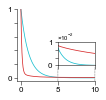

In [86]:
plt.figure(figsize=(1.3, 1.3))
plant_trange = np.arange(0, 10, 72*2e-4)
plt.plot(plant_trange, fitting_functions.exponentialModel(plant_trange, fast_plant), c='C9', lw=0.75, label=r'Fastest 2 $\tau$ plant')
plt.plot(plant_trange, fitting_functions.exponentialModel(plant_trange, best_plants_ketamine[fish_num, :]), c='C3', lw=0.75, label=r'Best 4 $\tau$ plant')

ax = plt.gca()
plt.xlim([-0.5, 10])
# plt.ylim([1e-5, 1])
# plt.yscale('log')
# plt.xlabel('Time (s)')
# plt.ylabel('Inferred plant')
plt.ylim([-0.05, 1])
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels([0, '','','','',1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0.12, right=0.95, bottom=0.18, top=0.95)


ax1 = plt.axes([.555, .35, .395, .25])
# ax1 = plt.axes([.6, .35, .35, .25])
plt.plot(plant_trange[347:694], fitting_functions.exponentialModel(plant_trange[347:694], fast_plant), c='C9', lw=0.75)
plt.plot(plant_trange[347:694], fitting_functions.exponentialModel(plant_trange[347:694], best_plants_ketamine[fish_num, :]), c='C3', lw=0.75)
ax1.set_xticks([5, 10])
ax1.set_xticklabels([])
ax1.set_ylim([0, 1e-2])
ax1.set_yticks(np.linspace(0,1e-2, 4))
ax1.set_yticklabels([0, '', '', 1])


ax1.set_xlim([5, 10])
plt.figtext(0.55, 0.62, r'$\times 10^{-2}$', fontsize=6)
ax.annotate("",xy=(5, 0.18), xytext=(5, -0.075),arrowprops={'arrowstyle':'-','ls':'--','lw':0.5, 'color':(0.5, 0.5, 0.5, 1)}, clip_on=False)
ax.annotate("",xy=(10, 0.18), xytext=(10, -0.075),arrowprops={'arrowstyle':'-','ls':'--','lw':0.5, 'color':(0.5, 0.5, 0.5, 1)}, clip_on=False);

# Calculate goodness-of-fit

In [11]:
def R2(data1, fit1, data2, fit2):
    sstot = np.sum((fit1 - np.mean(data1))**2) + np.sum((fit2 - np.mean(data2))**2)
    sse = np.sum((fit1 - data1)**2) + np.sum((fit2 - data2)**2)
    return 1-sse/sstot

In [20]:
def reconstruct(pe_short, pe_long, best_fits, plant_params, anaesthetic_type, mode='lsq_linear'):
    if anaesthetic_type == 'MS-222':
        short_duration = 10
        long_duration = 60
    elif anaesthetic_type == 'Ketamine':
        short_duration = 15
        long_duration = 90
    else:
        raise ValueError("Invalid anaesthetic type.")

    trange_deconv_mid = np.arange(0, int(0.2304/(72*2e-4))+1)*72*2e-4
    pe_short_deconv_mid = fitting_functions.exponentialModel(trange_deconv_mid, best_fits[0,:])
    pe_long_deconv_mid = fitting_functions.exponentialModel(trange_deconv_mid, best_fits[1,:])

    # Construct 10 s hold
    trange_short_deconv_pre = np.arange(0, short_duration, 72*2e-4)
    pe_short_deconv_pre = np.ones(len(trange_short_deconv_pre))
    # Construct 60 s hold
    trange_long_deconv_pre = np.arange(0, long_duration, 72*2e-4)
    pe_long_deconv_pre = np.ones(len(trange_long_deconv_pre))

    trange_short_deconv = np.concatenate((trange_short_deconv_pre, short_duration + trange_deconv_mid, short_duration+trange[1:]))
    trange_long_deconv = np.concatenate((trange_long_deconv_pre, long_duration + trange_deconv_mid, long_duration+trange[1:]))

    pe_short_deconv = np.concatenate((pe_short_deconv_pre, pe_short_deconv_mid, pe_short[1:]))
    pe_long_deconv = np.concatenate((pe_long_deconv_pre, pe_long_deconv_mid, pe_long[1:]))

    # Best reconstruction
    plant_model_best_short = fitting_functions.exponentialModel(trange_short_deconv, plant_params)
    f_best_short = np.zeros(len(trange_short_deconv))
    f_best_short[:len(pe_short_deconv_pre)] = deconvolveEyePos(trange_short_deconv_pre, pe_short_deconv_pre, plant_params, mode=mode)
    reconstr_best_short = 72*2e-4*np.convolve(plant_model_best_short, f_best_short)[:len(plant_model_best_short)]

    plant_model_best_long = fitting_functions.exponentialModel(trange_long_deconv, plant_params)
    f_best_long = np.zeros(len(trange_long_deconv))
    f_best_long[:len(pe_long_deconv_pre)] = deconvolveEyePos(trange_long_deconv_pre, pe_long_deconv_pre, plant_params, mode=mode)
    reconstr_best_long = 72*2e-4*np.convolve(plant_model_best_long, f_best_long)[:len(plant_model_best_long)]

    return reconstr_best_short[len(trange_short_deconv_pre)+len(trange_deconv_mid):], reconstr_best_long[len(trange_long_deconv_pre)+len(trange_deconv_mid):]

In [ ]:
num_components = 4

r2_deconv_ms222 = np.zeros(len(ms222_traces))

dt = 72*2e-4

for i in tqdm.notebook.trange(len(ms222_traces)):
    trace = ms222_traces[i]
    # load time constants
    trange, pe_short, pe_long = fitting_functions.importDataMS222('../../data/anesthetized/fixed/MS-222/'+ms222_traces[i]+'.mat')
    best_fits = loadBestFits('fit/results/MS-222/'+trace+'.mat', num_components)

    timeconstants = best_fits[0, num_components:]
    # load coefficients
    deconv_file = sio.loadmat('deconv/results/MS-222/'+trace+'/distributed/linear.mat')
    plant_params = np.concatenate((deconv_file['c'][0], timeconstants))
    trange_full = np.arange(0, trange[-1]/dt)*dt
    plant = fitting_functions.exponentialModel(trange_full, plant_params)
    reconstr_best_short, reconstr_best_long = reconstruct(pe_short, pe_long, best_fits, plant_params, 'MS-222')
    
    r2_deconv_ms222[i] = R2(pe_short[1:], reconstr_best_short, pe_long[1:], reconstr_best_long)

In [24]:
r2_deconv_ms222

array([0.90398036, 0.93085897, 0.68763905, 0.88841158, 0.83958146,
       0.9019527 , 0.92018189, 0.91619974, 0.85461451, 0.85870572])

In [ ]:
r2_deconv_ketamine = np.zeros(len(ketamine_traces))

for i in tqdm.notebook.trange(len(ketamine_traces)):
    trace = ketamine_traces[i]
    # load time constants
    trange, pe_short, pe_long = fitting_functions.importDataKetamine('../../data/anesthetized/fixed/Ketamine/'+ketamine_traces[i]+'.mat')
    best_fits = loadBestFits('fit/results/Ketamine/'+trace+'.mat', num_components)

    timeconstants = best_fits[0, num_components:]
    # load coefficients
    deconv_file = sio.loadmat('deconv/results/Ketamine/'+trace+'/distributed/linear.mat')
    plant_params = np.concatenate((deconv_file['c'][0], timeconstants))
    trange_full = np.arange(0, trange[-1]/dt)*dt
    plant = fitting_functions.exponentialModel(trange_full, plant_params)
    reconstr_best_short, reconstr_best_long = reconstruct(pe_short, pe_long, best_fits, plant_params, 'Ketamine')
    
    r2_deconv_ketamine[i] = R2(pe_short[1:], reconstr_best_short, pe_long[1:], reconstr_best_long)

In [29]:
r2_deconv_ketamine

array([0.88076879, 0.75125716, 0.84987773, 0.94849976, 0.87329374,
       0.90835354])

In [30]:
np.mean(np.concatenate((r2_deconv_ms222, r2_deconv_ketamine)))

0.8696360434383609

In [31]:
np.std(np.concatenate((r2_deconv_ms222, r2_deconv_ketamine)))

0.06503788713817914